### Primero redimensionamos las imágenes a 2048 
Todo este fichero se ejecuta con los datos en el disco duro interno, ya que, vamos a trabajar con un mayor volumen de datos y el externo retrasaría la carga de los datos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import scandir, getcwd
import pickle
import pandas as pd
import random
import re
import shutil

In [2]:
# Leemos los archivos pickle donde están las imágenes
listImgTrain = []
with open("listImgTrain.pickle", "rb") as f:
    listImgTrain = pickle.load(f)

listImgVal = []
with open("listImgVal.pickle", "rb") as f:
    listImgVal = pickle.load(f)

Tenemos en una carpeta todas las imágenes del Dataset A y Dataset B juntas. Las redimensionamos y las ponemos en carpetas en función de si será para Train o Val.

In [61]:
#Redimensionamos todas las imagenes a 2048
for img in listImgTrain:
    redim = Image.open("Dataset/Imagenes/"+img)
    nuevo = redim.resize((2048, 2048), Image.ANTIALIAS)
    nuevo.save("Dataset/img 1024/Train/"+img)

In [11]:
for img in listImgVal:
    redim = Image.open("Dataset/Imagenes/"+img)
    nuevo = redim.resize((2048, 2048), Image.ANTIALIAS)
    nuevo.save("Dataset/img 1024/Validation/"+img)

### Cargar los CSV formateados de la prueba 9
Obteniendo un CSV de Train y un CSV de Val.

In [3]:
dfTrain = pd.read_csv("Dataset/seg 2048/TrainTODOS-Format.csv")
dfVal = pd.read_csv("Dataset/seg 2048/ValTODOS-Format.csv")

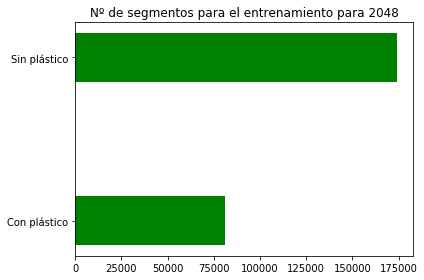

Segmentos con plástico:  80864
Segmentos sin plasticos:  174212


In [4]:
def visualizarClases(dfConcat, title, ruta):
    #Contamos cuantos fragmentos tenemos con/sin plásticos
    unos = dfConcat[dfConcat['Plasticos'] == 1].count()
    ceros = dfConcat[dfConcat['Plasticos'] == 0].count()

    #Graficos de barras bonicos ---> https://plot.ly/matplotlib/bar-charts/
    plt.barh(["Con plástico","Sin plástico"],[unos.values[0],ceros.values[0]],color="Green",height=0.3)
    plt.title(title)
    plt.tight_layout() #Evitamos que se corten las leyendas del gráfico con size también se arregla
    plt.savefig(ruta, pad_inches=30)
    plt.show()
    
    print("Segmentos con plástico: ", unos[0])
    print("Segmentos sin plasticos: ", ceros[0])
    
visualizarClases(dfTrain,"Nº de segmentos para el entrenamiento para 2048","NSegmentosImg-2048Train.jpg")

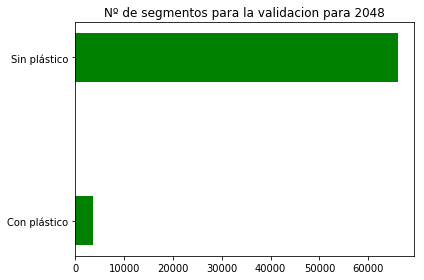

Segmentos con plástico:  3532
Segmentos sin plasticos:  66100


In [5]:
visualizarClases(dfVal,"Nº de segmentos para la validacion para 2048","NSegmentosImg-2048Val.jpg")

### Segmentamos las imágenes

In [12]:
n = int(2048/32) #64

unosListTrain = dfTrain[dfTrain['Plasticos'] == 1]['Nombre Segmento'].tolist() #Para clasificar en carpetas
print(len(unosListTrain))
paraDataAug = [] #Con los nombres de los segmentos tipo 01 y 04 (2 digitos)

for img in listImgTrain:
    recort = Image.open("Dataset/img 2048/Train/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*32,j*32,i*32+32,j*32+32))
            subtring = img[0:-4]
            seg = "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)
            if seg in unosListTrain:
                region.save("Dataset/seg 2048/Train/plastico/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
                paraDataAug.append("imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            else:
                region.save("Dataset/seg 2048/Train/arena/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            

len(paraDataAug)

80864


10108

In [52]:
n = int(2048/32) #64
unosListVal = dfVal[dfVal['Plasticos'] == 1]['Nombre Segmento'].tolist() #Para clasificar en carpetas

for img in listImgVal:
    recort = Image.open("Dataset/img 2048/Validation/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*32,j*32,i*32+32,j*32+32))
            subtring = img[0:-4]
            seg = "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)
            
            #Los guardamos también en la carpeta Predict para la matriz de confusión
            region.save("Dataset/seg 2048/Predict/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            
            if seg in unosListVal:
                region.save("Dataset/seg 2048/Validation/plastico/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            else:
                region.save("Dataset/seg 2048/Validation/arena/"+
                            "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")


### Data augmentation de los segmentos con plástico para Train 
Mismas trasformaciones que en las otras pruebas

In [14]:
prueba = paraDataAug[0]
print(prueba)
print((prueba[:-11] +"-DA_a"+ prueba[-11:len(prueba)]))

imgID-1-R05C54.jpg
imgID-1-DA_a-R05C54.jpg


In [15]:
#Bucle for para realizar el Data Augmentation
totalAug = []
for i in paraDataAug:
    imagenOriginal = Image.open("Dataset/seg 2048/Train/plastico/"+i)

    imagen90 = imagenOriginal.transpose(Image.ROTATE_90)
    totalAug.append(i[:-11] +"-DA_a"+ i[-11:len(i)])
    imagen90.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_a"+ i[-11:len(i)])
    
    imagen180 = imagenOriginal.transpose(Image.ROTATE_180)
    totalAug.append(i[:-11] +"-DA_b"+ i[-11:len(i)])
    imagen180.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_b"+ i[-11:len(i)])
    
    imagen270 = imagenOriginal.transpose(Image.ROTATE_270)
    totalAug.append(i[:-11] +"-DA_c"+ i[-11:len(i)])
    imagen270.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_c"+ i[-11:len(i)])
    
    imagenTOPMirror = imagenOriginal.transpose(Image.FLIP_TOP_BOTTOM)
    totalAug.append(i[:-11] +"-DA_d"+ i[-11:len(i)])
    imagenTOPMirror.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_d"+ i[-11:len(i)])
    
    imagenLEFTMirror = imagenOriginal.transpose(Image.FLIP_LEFT_RIGHT)
    totalAug.append(i[:-11] +"-DA_e"+ i[-11:len(i)])
    imagenLEFTMirror.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_e"+ i[-11:len(i)])
    
    imagenTRANSVERSE = imagenOriginal.transpose(Image.TRANSVERSE)
    totalAug.append(i[:-11] +"-DA_f"+ i[-11:len(i)])
    imagenTRANSVERSE.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_f"+ i[-11:len(i)])
    
    imagenTRANSPOSE = imagenOriginal.transpose(Image.TRANSPOSE)
    totalAug.append(i[:-11] +"-DA_g"+ i[-11:len(i)])
    imagenTRANSPOSE.save("Dataset/seg 2048/Train/plastico/"+i[:-11] +"-DA_g"+ i[-11:len(i)])
    

print(len(totalAug))

70756


### Preparacion de los datos para la Red

In [16]:
unosList = dfTrain[dfTrain['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfTrain[dfTrain['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))

random.shuffle(cerosList)
random.shuffle(unosList)
mover = cerosList[len(unosList):]
cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  80864
Imágenes sin plásticos:  174212
Ahora igualamos el nº de elementos: 
cerosList =  80864


In [17]:
for i in mover:
    shutil.move("Dataset/seg 2048/Train/arena/"+i+".jpg", "Dataset/seg 2048/Train arena extra")


In [18]:
#Preparamos el conjunto de Validación
unosList = dfVal[dfVal['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfVal[dfVal['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))

random.shuffle(cerosList)
random.shuffle(unosList)
mover = cerosList[len(unosList):]
cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  3532
Imágenes sin plásticos:  66100
Ahora igualamos el nº de elementos: 
cerosList =  3532


In [20]:
for i in mover:
    shutil.move("Dataset/seg 2048/Validation/arena/"+i+".jpg", "Dataset/seg 2048/Val arena extra")

## Red Neuronal

In [21]:
from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD
from keras.callbacks             import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image   import ImageDataGenerator

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
#Creamos datos
datagen = ImageDataGenerator(rescale=1./255)
Train_directory = datagen.flow_from_directory("Dataset/seg 2048/Train", target_size=(32, 32), batch_size=32, class_mode='binary')

datagen2 = ImageDataGenerator(rescale = 1./255)
Val_directory = datagen2.flow_from_directory("Dataset/seg 2048/Validation",target_size=(32, 32), batch_size=32, class_mode='binary')

Found 161728 images belonging to 2 classes.
Found 7064 images belonging to 2 classes.


In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [25]:
#Primero entrenamos con los datos separados con sklearn
model_checkpoint = ModelCheckpoint('RedPesos-2048.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
history = model.fit_generator(Train_directory, steps_per_epoch=20, epochs=30, validation_data=Val_directory, validation_steps=10, callbacks=[model_checkpoint])

Epoch 1/30
20/20 [==============================] - 18s 916ms/step - loss: 0.7031 - acc: 0.4984 - val_loss: 0.6643 - val_acc: 0.9750

Epoch 00001: val_loss improved from inf to 0.66435, saving model to RedPesos-2048.hdf5
Epoch 2/30
20/20 [==============================] - 16s 807ms/step - loss: 0.6849 - acc: 0.5422 - val_loss: 0.6148 - val_acc: 0.9719

Epoch 00002: val_loss improved from 0.66435 to 0.61481, saving model to RedPesos-2048.hdf5
Epoch 3/30
20/20 [==============================] - 17s 844ms/step - loss: 0.6945 - acc: 0.5031 - val_loss: 0.7307 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.61481
Epoch 4/30
20/20 [==============================] - 16s 788ms/step - loss: 0.6791 - acc: 0.5484 - val_loss: 0.7616 - val_acc: 0.4781

Epoch 00004: val_loss did not improve from 0.61481
Epoch 5/30
20/20 [==============================] - 16s 778ms/step - loss: 0.6788 - acc: 0.5531 - val_loss: 0.7653 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve from

In [26]:
#GUARDAMOS EL MODELO
model.save('RedPesos-2048Training.hdf5')

In [27]:
#Volvemos a entrenar el modelo a ver si mejora
model_checkpoint = ModelCheckpoint('RedPesos-2048-2time.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(Train_directory, steps_per_epoch=20, epochs=20, validation_data=Val_directory, validation_steps=10, callbacks=[model_checkpoint])

Epoch 1/20
20/20 [==============================] - 12s 608ms/step - loss: 0.4236 - acc: 0.8188 - val_loss: 1.4750 - val_acc: 0.6969

Epoch 00001: loss improved from inf to 0.42357, saving model to RedPesos-2048-2time.hdf5
Epoch 2/20
20/20 [==============================] - 14s 709ms/step - loss: 0.4067 - acc: 0.8266 - val_loss: 1.8739 - val_acc: 0.5437

Epoch 00002: loss improved from 0.42357 to 0.40669, saving model to RedPesos-2048-2time.hdf5
Epoch 3/20
20/20 [==============================] - 11s 555ms/step - loss: 0.3861 - acc: 0.8438 - val_loss: 1.7382 - val_acc: 0.6125

Epoch 00003: loss improved from 0.40669 to 0.38610, saving model to RedPesos-2048-2time.hdf5
Epoch 4/20
20/20 [==============================] - 14s 683ms/step - loss: 0.3894 - acc: 0.8266 - val_loss: 1.1131 - val_acc: 0.7094

Epoch 00004: loss did not improve from 0.38610
Epoch 5/20
20/20 [==============================] - 14s 677ms/step - loss: 0.3500 - acc: 0.8422 - val_loss: 1.3028 - val_acc: 0.7125

Epoch 00

In [28]:
#Cargamos los pesos del modelo
model.load_weights('RedPesos-2048-2time.hdf5')   

In [39]:
from sklearn.metrics import confusion_matrix


model.evaluate_generator(Val_directory)
#pv_round = np.asarray([int(round(i)) for i in pv])
#conf_mat = confusion_matrix(Y_test, pv_round)
#conf_mat

[1.775681654432217, 0.6241506229440597]

### Matriz de confusión

In [42]:
X_testList = dfVal['Nombre Segmento'].tolist()

X_test = np.array([np.array(Image.open("Dataset/seg 2048/Predict/"+img + ".jpg")) for img in X_testList] )
print(X_test.shape)

(69632, 32, 32, 3)


In [43]:
X_test= X_test / 255.0

In [48]:
unosList = dfVal[dfVal['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfVal[dfVal['Plasticos'] == 0]['Nombre Segmento'].tolist()

Y_test = np.zeros((len(X_testList)))
for i in range(len(Y_test)):
    if X_testList[i] in unosList : 
        Y_test[i] = 1

print(len(Y_test))

69632


In [49]:
pv =  np.ravel(model.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
conf_mat

array([[60371,  5729],
       [ 1157,  2375]], dtype=int64)

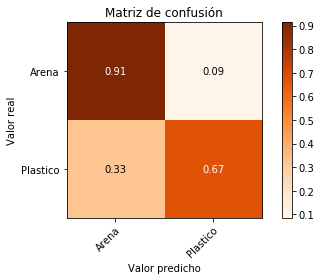

In [53]:
def matrixConfusion (conf_mat, cmap):
    
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]),
            yticks=np.arange(conf_mat.shape[0]),
            xticklabels=["Arena","Plastico"], yticklabels=["Arena","Plastico"],
            title='Matriz de confusión',
            ylabel='Valor real',
            xlabel='Valor predicho')
    
    # Rotate the tick labels and set their alignment.    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("MatrizConfusion-2048.jpg")
    
    plt.show()
    
matrixConfusion(conf_mat,'Oranges')

### Visualizar IMG con predict

In [30]:
from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD
from keras.callbacks             import ModelCheckpoint, LearningRateScheduler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from os import scandir, getcwd

In [90]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(16, 16, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [91]:
#Cargamos los pesos del modelo
model.load_weights('RedPesos-1024.hdf5')   

In [31]:
def lsTestIMG(imgName, ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if (arch.is_file() and arch.name.endswith('.jpg') 
                                                    and arch.name.startswith(imgName[0:-4]))] 
def segmentarImg(img):
    n = int(2048/32) 
    listaRegionesTest = []
    recort = Image.open("Dataset/img 2048/Test/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*32,j*32,i*32+32,j*32+32))
            subtring = img[0:-4]
            region.save("Dataset/seg 2048/Test/"+
                        "imgID-"+subtring+"-R"+"{0:0=3d}".format(i)+"C"+"{0:0=3d}".format(j)+".jpg")
            listaRegionesTest.append("imgID-"+subtring+"-R"+"{0:0=3d}".format(i)+"C"+"{0:0=3d}".format(j)+".jpg")
    return listaRegionesTest
    
def evaluarVisualizarIMG(imagenPaVer):
    
    n = int(2048/32)
    
    listNuevasPruebas = lsTestIMG("imgID-"+imagenPaVer,
                                  "Dataset/seg 2048/Test/")
    
    #Hay que segmentarla si no está segmentada o faltan segmentos
    if (not listNuevasPruebas) or (len(listNuevasPruebas)<n*n):
        listNuevasPruebas = segmentarImg(imagenPaVer)
        
    arrayNuevasPruebas = np.array([np.array(
                            Image.open("Dataset/seg 2048/Test/"+img)) 
                                   for img in listNuevasPruebas])
    arrayNuevasPruebas = arrayNuevasPruebas / 255.0

    evalNuevasPruebas =  np.ravel(model.predict(arrayNuevasPruebas))
    
    print(type(evalNuevasPruebas))
    print(evalNuevasPruebas.shape)
    
    
    evalNuevasPruebas = np.asarray([int(round(i)) for i in evalNuevasPruebas])
    counterNuevasPruebas = np.count_nonzero(evalNuevasPruebas)
    
            
    listVisual = np.asarray(listNuevasPruebas).reshape((n,n))
    evalVisual = evalNuevasPruebas.reshape((n, n))
    fondo = Image.new('RGBA', (2048, 2048), "black") 
    mask = Image.new('RGBA', (2048, 2048), "black") 
    blanco = Image.new('RGBA', (32, 32), "white")
    
    for i in range(0,n):
        for j in range(0,n):
            if evalVisual[i][j] == 1:
                imagen = Image.open("Dataset/seg 2048/Test/"+listVisual[i][j])
                fondo.paste(imagen,(i*32,j*32))
                mask.paste(blanco,(i*32,j*32))
    
    fondo.save("%s_predict.png" %imagenPaVer[0:-4])
    mask.save("%s_mask.png"  %imagenPaVer[0:-4])  
    
    plt.figure(figsize=(15,15))
    plt.subplot(111)
    plt.axis('off')
    plt.title(imagenPaVer)
    array = np.array(fondo)
    plt.imshow(array) 

<class 'numpy.ndarray'>
(4096,)


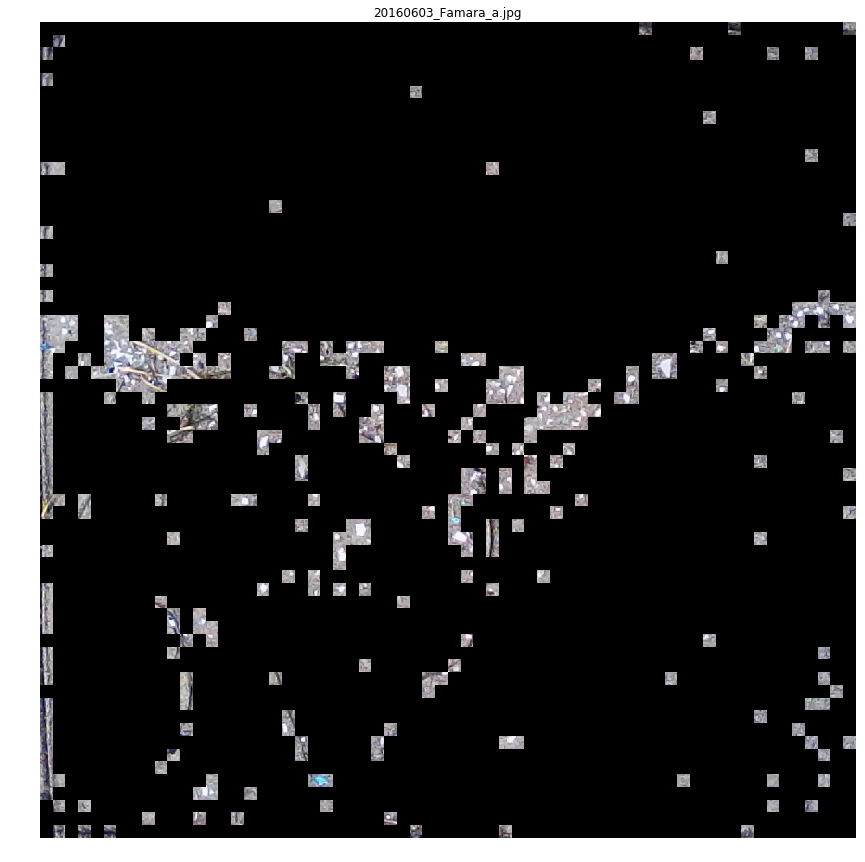

In [33]:
evaluarVisualizarIMG("20160603_Famara_a.jpg")

<class 'numpy.ndarray'>
(4096,)


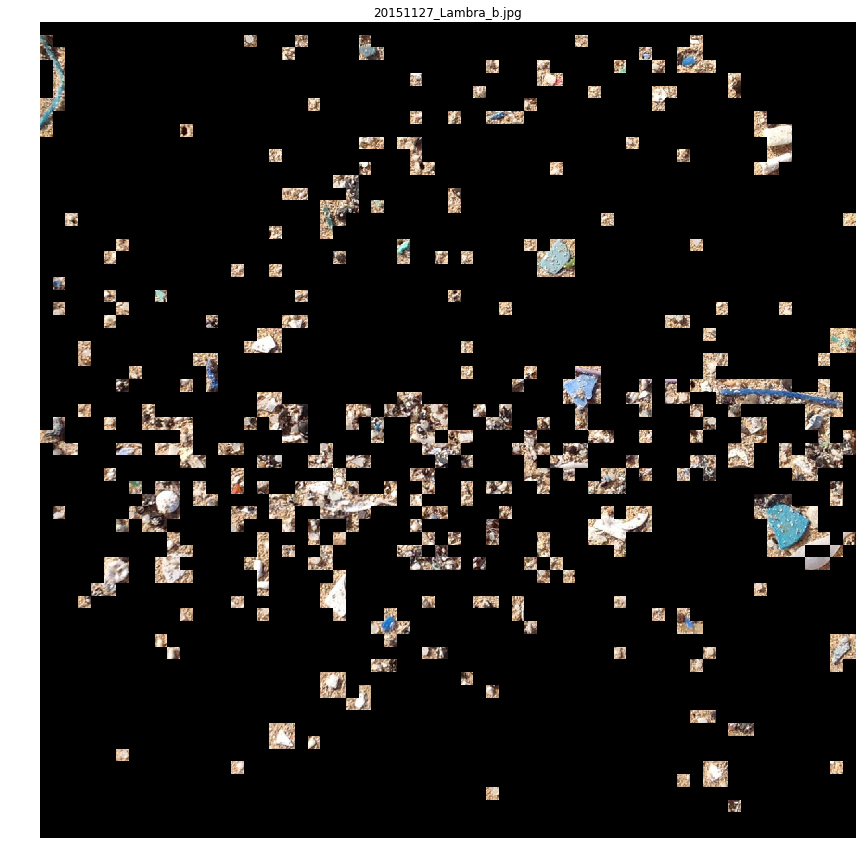

In [34]:
evaluarVisualizarIMG("20151127_Lambra_b.jpg")

<class 'numpy.ndarray'>
(4096,)


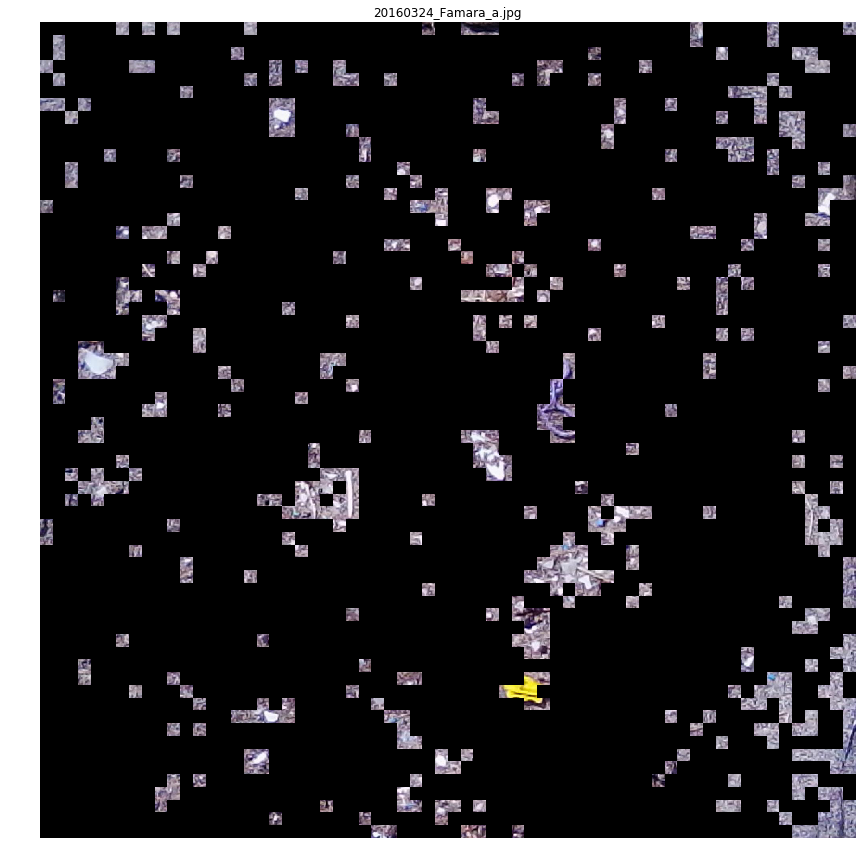

In [35]:
evaluarVisualizarIMG("20160324_Famara_a.jpg")

<class 'numpy.ndarray'>
(4096,)


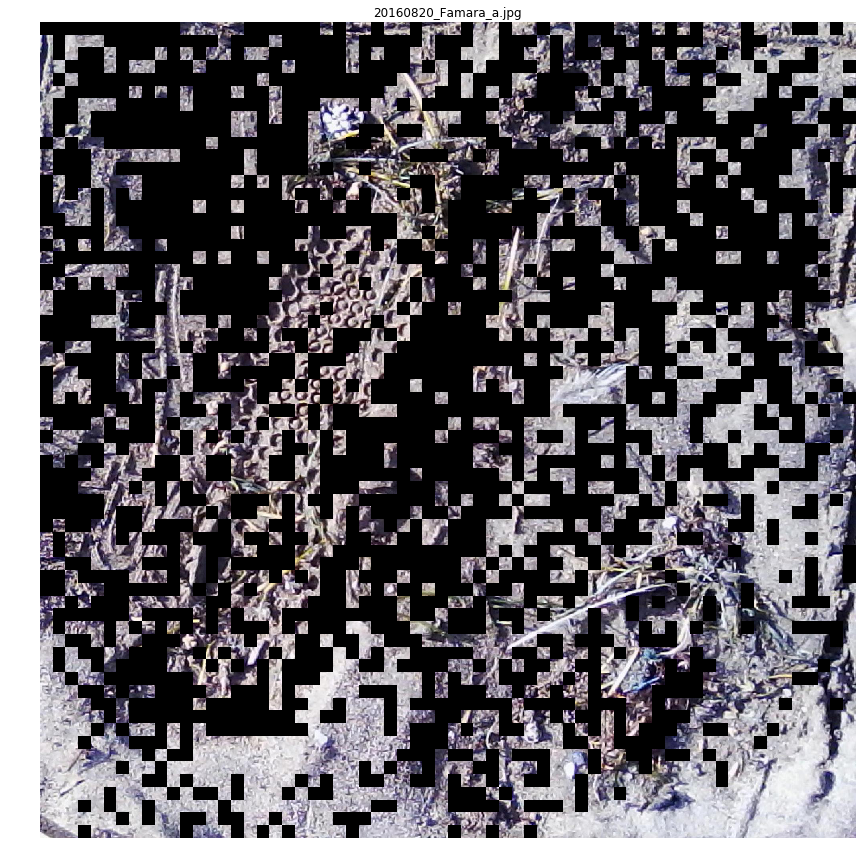

In [36]:
evaluarVisualizarIMG("20160820_Famara_a.jpg")

<class 'numpy.ndarray'>
(4096,)


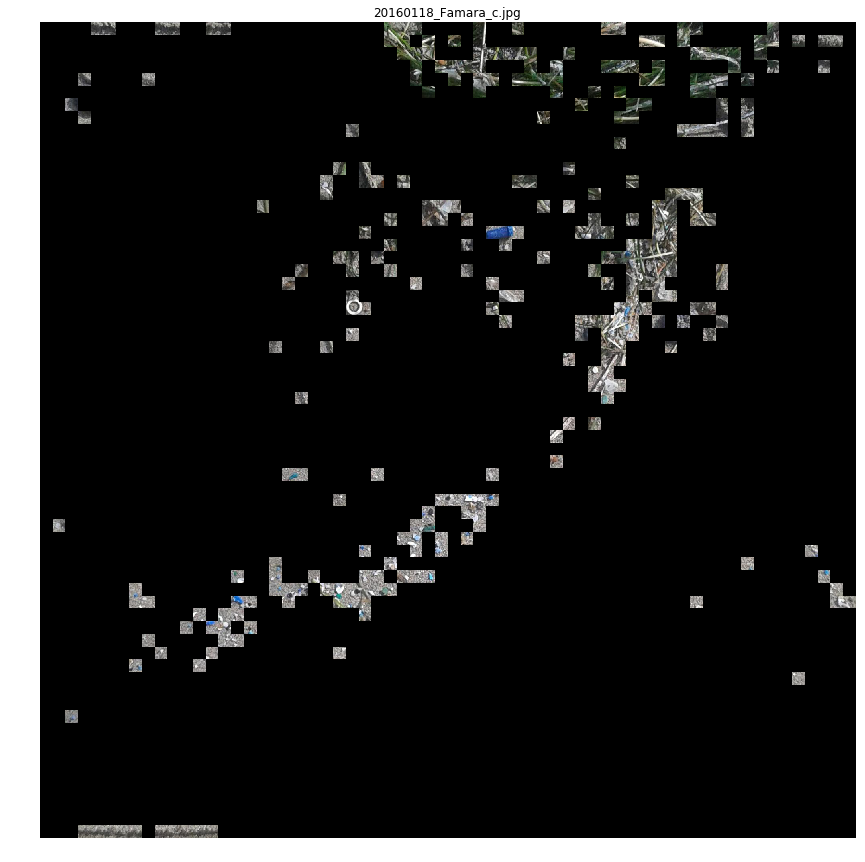

In [37]:
evaluarVisualizarIMG("20160118_Famara_c.jpg")

<class 'numpy.ndarray'>
(4096,)


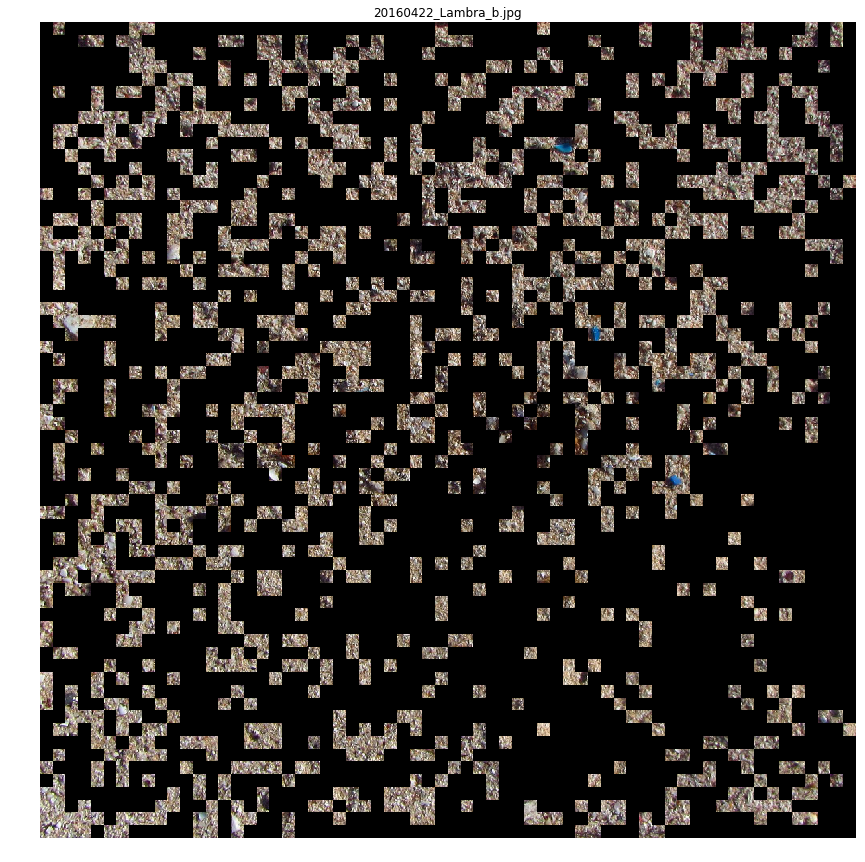

In [38]:
evaluarVisualizarIMG("20160422_Lambra_b.jpg")